## Advanced Lane Finding Project


Steps for the pipeline are;

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Detect lane lines
1. Determine the lane curvatur

In [1]:
# Code cell 1
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



## Calibrate The Camera

In [2]:
# Code Cell 2
class CalibrateCamera:
    # Note these are class variables, so you only every have to read images once
    ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
    objpoints = []
    imgpoints = []
    cal_images = []
    
    def __init__(self):
        self.readCalibrationImages()

    def readCalibrationImages(self):
        if len (self.cal_images) > 0:
            return
        # prepare object points
        nx = 9 #TODO: enter the number of inside corners in x
        ny = 6 #TODO: enter the number of inside corners in y

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coord

        images = glob.glob("./camera_cal/*.jpg")

        # Make a list of calibration images

        for fname in images:
            print (fname)
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                #print (corners[0], corners[nx-1],corners[-1],corners[-nx])

            self.cal_images.append((img,fname))

    def getCalibrationImages(self):
        return self.cal_images
    
    def getCameraCalibration(self,image_shape):
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, image_shape, None, None)

    def undistortImage(self,image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)

./camera_cal/calibration5.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


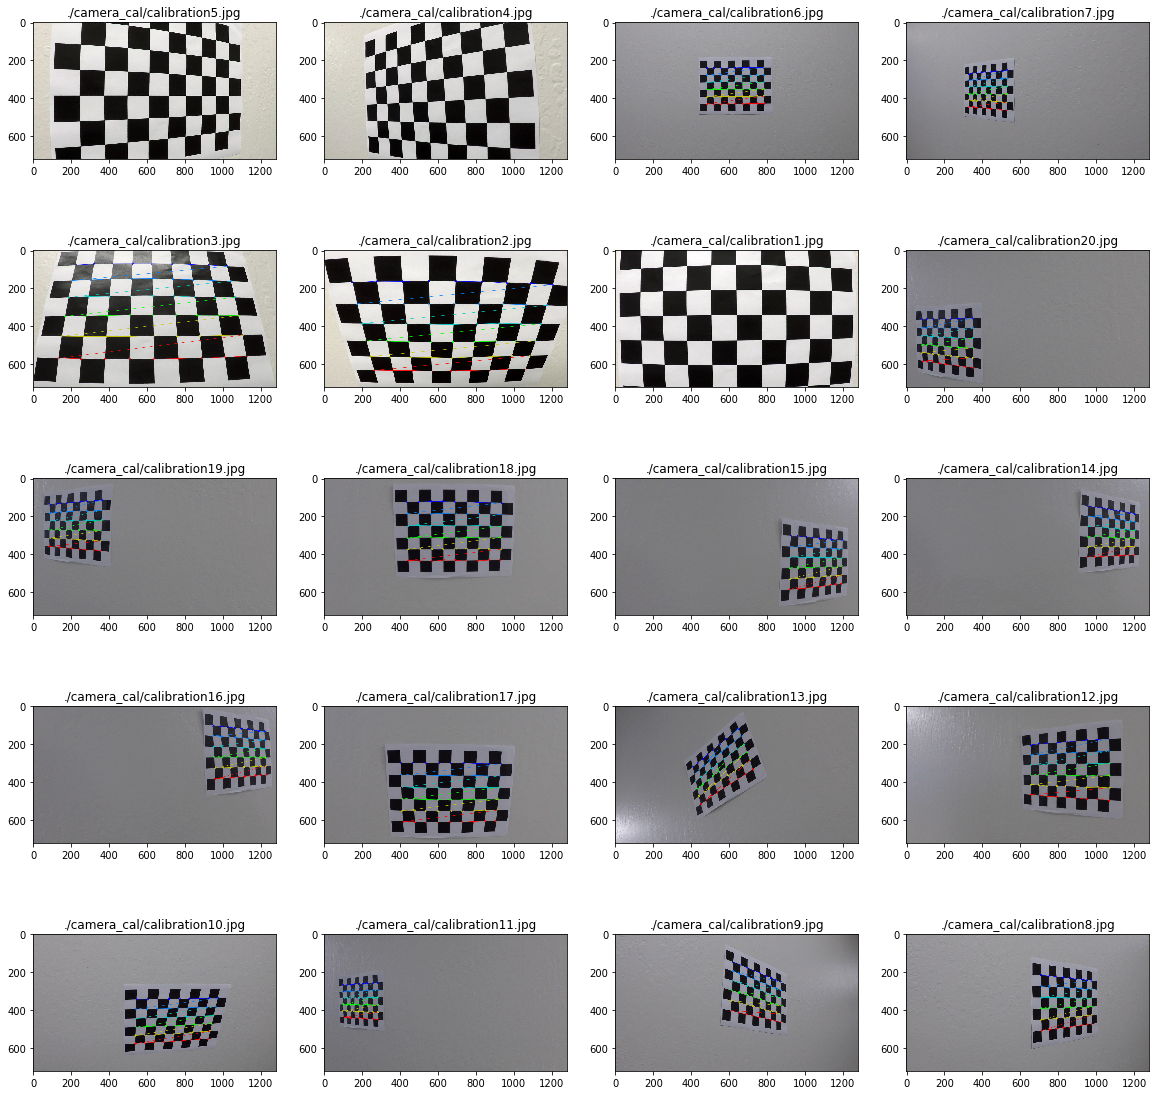

In [3]:
#Code Cell 3
camCal = CalibrateCamera()

cal_images = camCal.getCalibrationImages()


f, ax = plt.subplots(5, 4, figsize=(20, 20))

ax = ax.ravel()

for cal_image,axi in zip(cal_images,ax):
    axi.imshow(cal_image[0])
    axi.set_title(cal_image[1])

plt.subplots_adjust(hspace=0.3)
plt.show()



## Threshold Functions

## Show Chessboard Undistorted

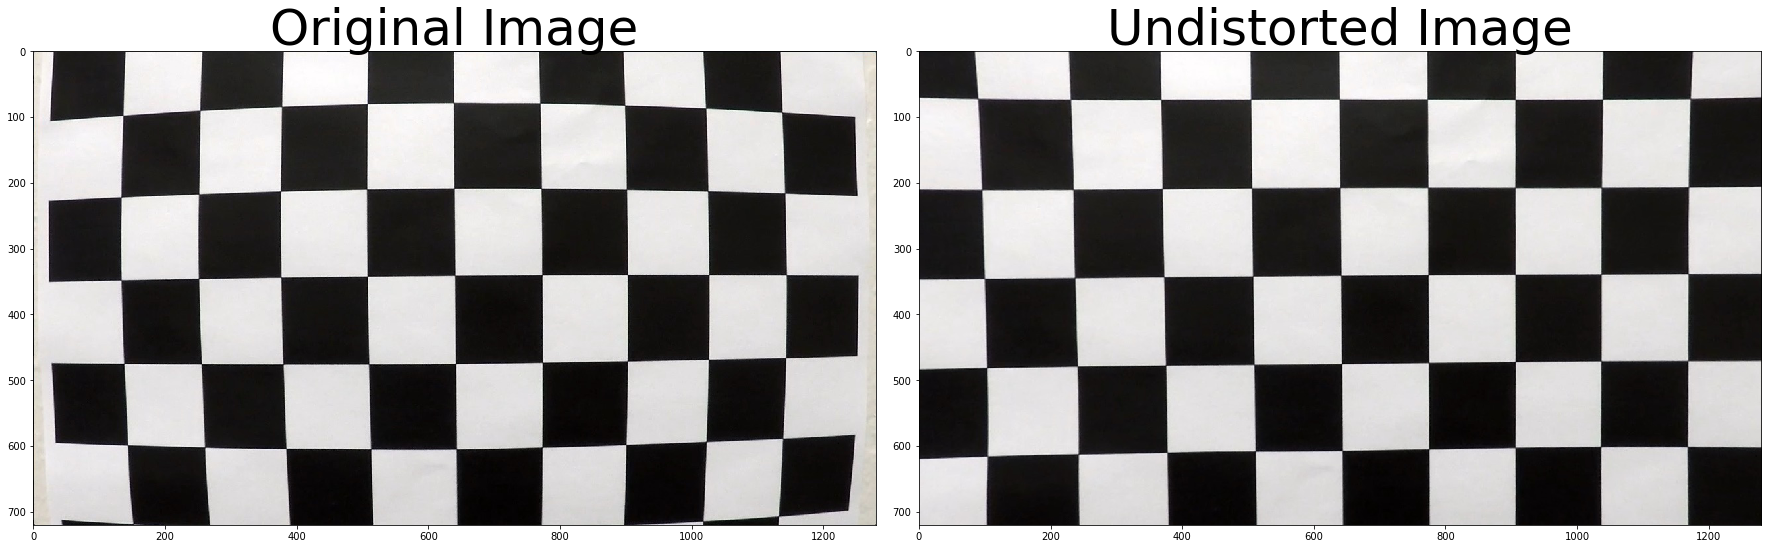

In [4]:
#Code Cell 4
cal_image = mpimg.imread("./camera_cal/calibration1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort Test Image

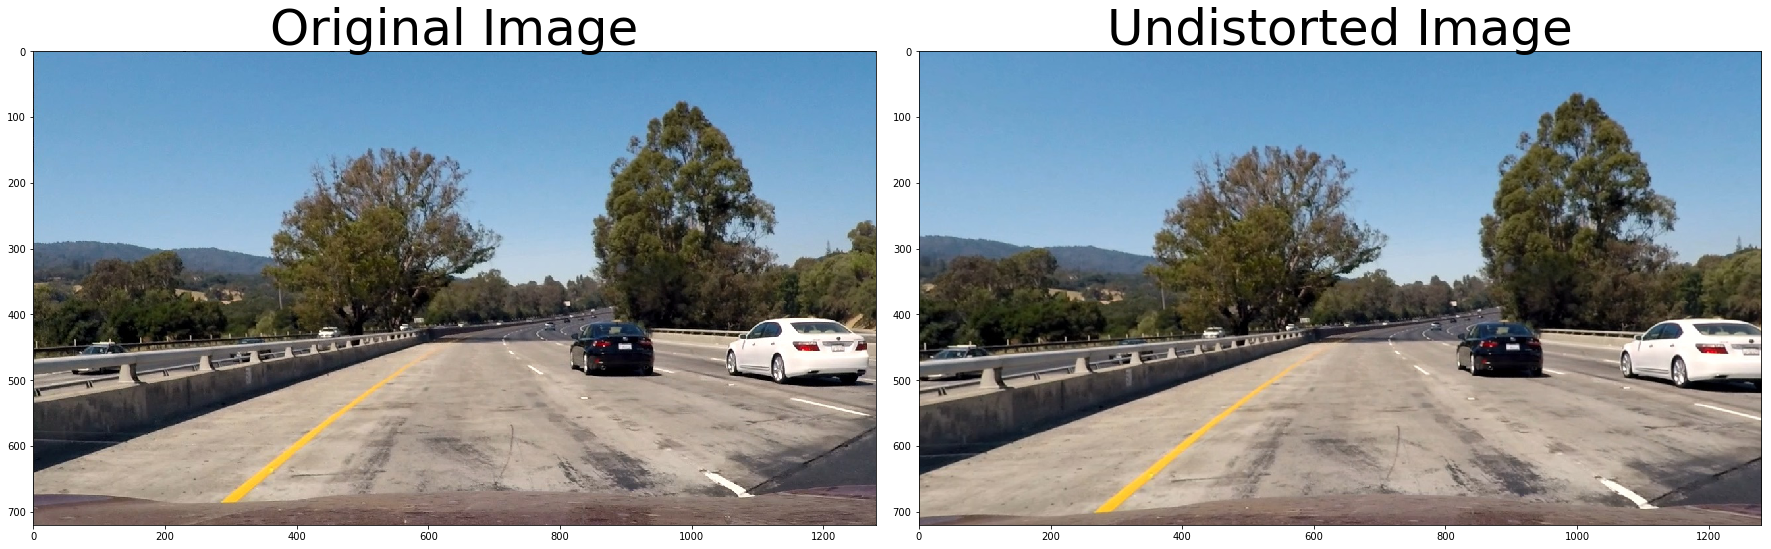

In [5]:
#Code Cell 5
cal_image = mpimg.imread("./test_images/test1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient & Threshold functions


In [6]:
#Code Cell 6
# Class that takes an image and lets you pick appropriate Channels from different
# Color spaces
class ImageChannel():
    image = None
    def __init__(self,img):
        # Initial RGB image
        self.image = img

    def getChannel(self, channel):
        """Dispatch method"""
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, channel, lambda: "nothing")
        # Call the method as we return it
        return method()

    def GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    def RGB_R(self):
        return image[:,:,0]

    def RGB_G(self):
        return image[:,:,1]

    def RGB_B(self):
        return image[:,:,2]

    def HLS_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HLS_L(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HLS_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    def HSV_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HSV_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HSV_V(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]

    
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel="GRAY", sobel_kernel=3, thresh=(0,255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, channel="GRAY", sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, channel="GRAY", sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh (img, channel="GRAY", thresh=(170,255)):
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)

    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary



## Gradient & Threshold Visualizations

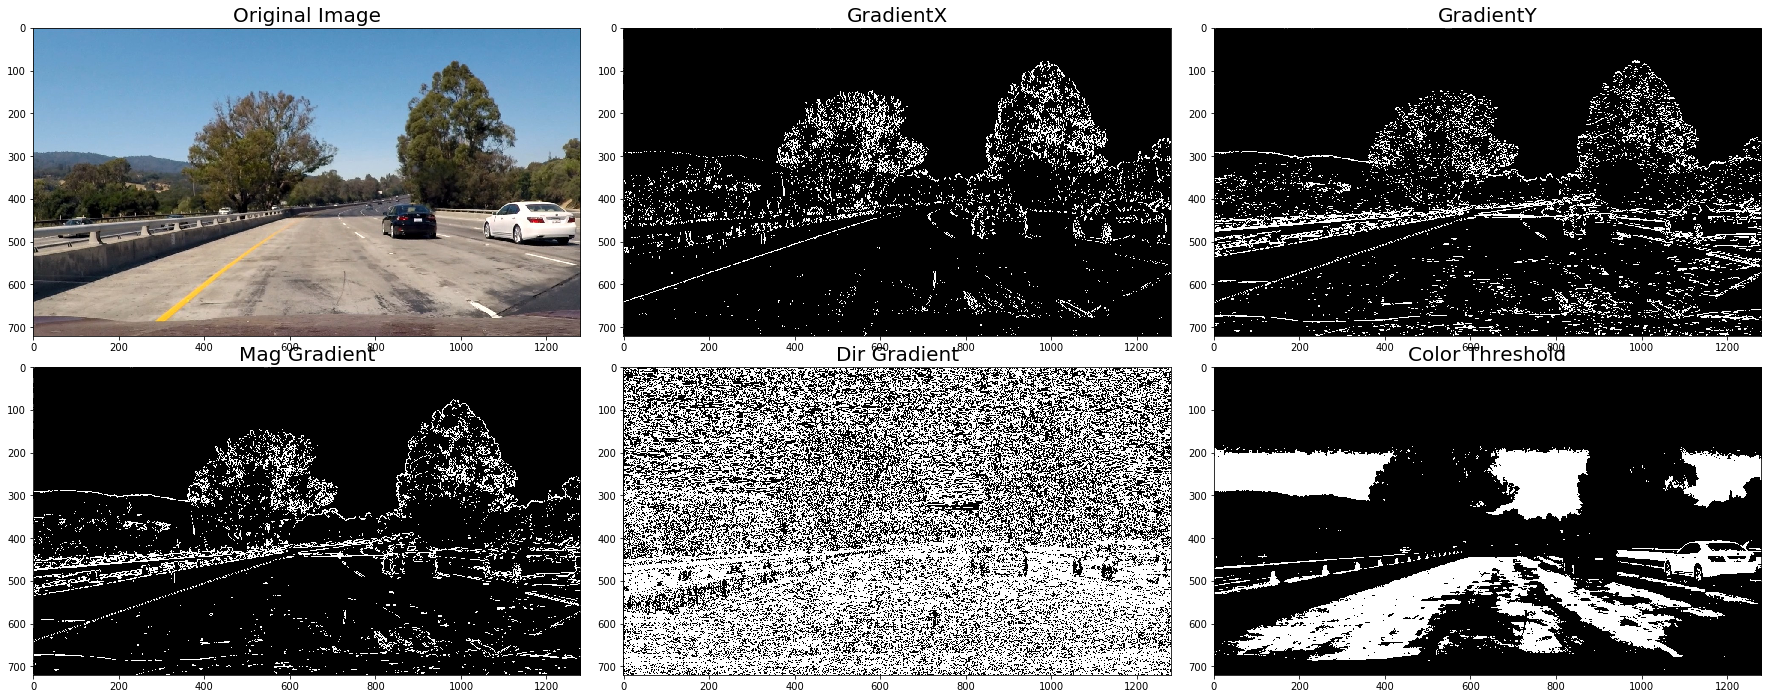

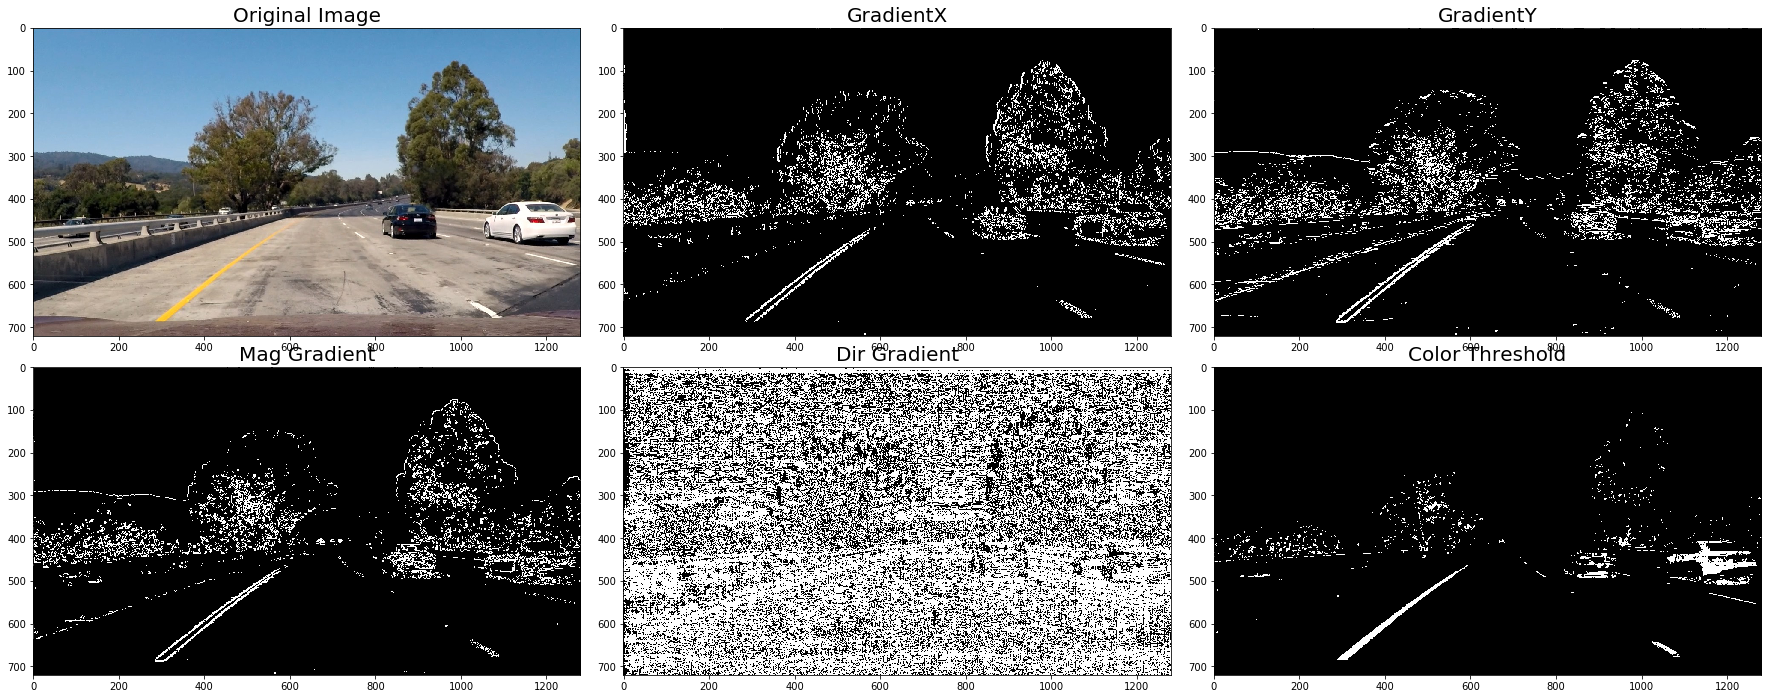

In [7]:
#Code Cell 7
# Read in an image and grayscale it
ksize = 3
image = mpimg.imread('./test_images/test1.jpg')

gradx = abs_sobel_thresh(image, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="GRAY", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="GRAY", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="GRAY", thresh=(170,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

gradx = abs_sobel_thresh(image, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="HLS_S", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="HLS_S", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="HLS_S", thresh=(150,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

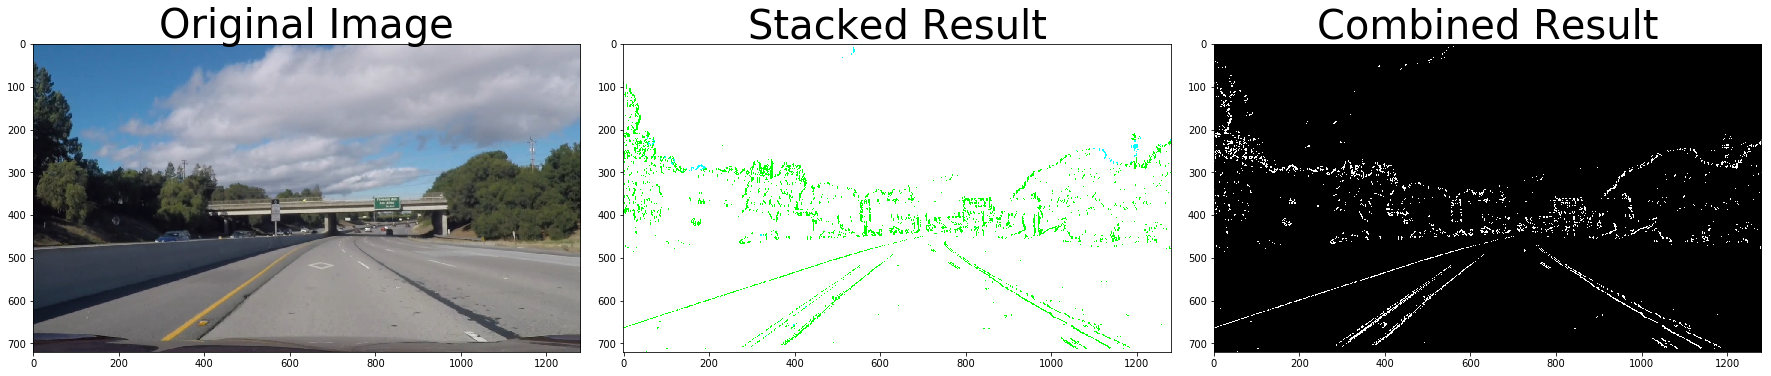

In [18]:
#Code Cell 8
image = mpimg.imread('./test_images/test11.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    undistorted = camCal.undistortImage(img)


    gradx_g = abs_sobel_thresh(undistorted, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 150))
    grady_g = abs_sobel_thresh(undistorted, orient='y', channel="GRAY", sobel_kernel=15, thresh=(20, 150))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(15, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    gradx_l = abs_sobel_thresh(undistorted, orient='x', channel="HLS_L", sobel_kernel=ksize, thresh=(20, 100))
    gradx_s = abs_sobel_thresh(undistorted, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
    color_s = color_thresh(image, channel="HLS_S", thresh=(100, 255))
    color_l = color_thresh(image, channel="HLS_L", thresh=(220, 255))
    color_v = color_thresh(image, channel="HSV_V", thresh=(210, 255))

    #color_t = color_thresh(undistorted, channel="HLS_S", thresh=(150,255))


    color_binary = np.dstack(( np.zeros_like(gradx_g), gradx_g, color_s, gradx_g)) * 255
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[(gradx_l ==1) | (color_t ==1) | (gradx_s==1) ] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_l == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[((gradx_l == 1) & (gradx_s == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[(gradx_g == 1) | (color_s == 1) | (color_v == 1)] = 1


    return color_binary, combined_binary
    
stacked, combined = pipeline(image)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(stacked, cmap="gray")
ax2.set_title('Stacked Result', fontsize=40)

ax3.imshow(combined, cmap="gray")
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## Perspective Transform

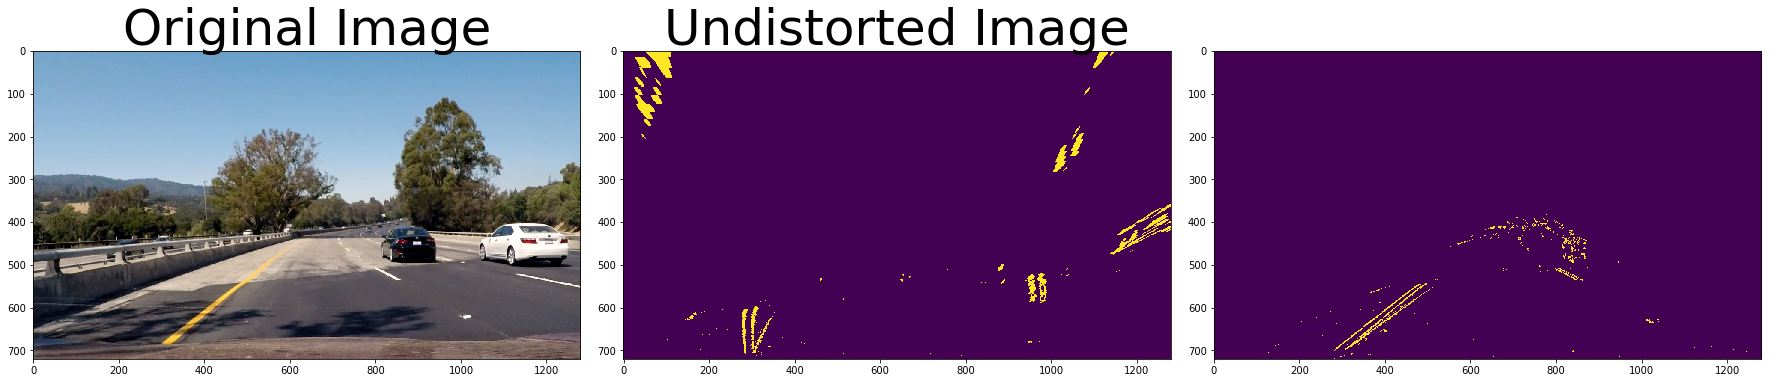

In [19]:
#Code Cell 9
def get_transform_matrix():
    img = mpimg.imread('test_images/straight_lines1.jpg')
    h,w= img.shape[:2]

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])

#    src = np.float32(
#        [[685, 450], 
#          [1100, 710], 
#          [200, 710], 
#          [595, 450]])
#    
#    dst = np.float32(
#        [[900, 0], 
#          [900, 710], 
#          [250, 710], 
#          [250, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

# Remove a region of an image
def remove_region(img, triangle):
    mask = np.ones_like(img) 
    mask = cv2.fillPoly(mask, [triangle], 0)

    new_combined = np.zeros_like(img)
    new_combined[((img == 1) & (mask == 1))] = 1
    
    return new_combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cal_image = mpimg.imread("./test_images/test4.jpg")

stacked,processed = pipeline(cal_image)

# Remove a piece of the road between te lanes. This removes some noise that may be in between the lane lines
#h,w= processed.shape[:2]
#triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
#processed = remove_region(processed, triangle)
pHeightMask=1.7
imshape = cal_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/pHeightMask, imshape[0]/2), (imshape[1]/pHeightMask, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
processed = region_of_interest(processed,vertices)
    
M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(processed)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

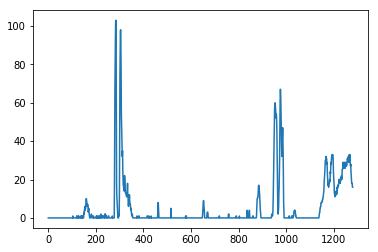

In [20]:
#Code Cell 10
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Orig Sliding Window


(720, 0)

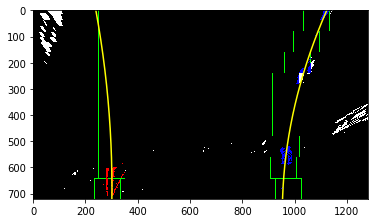

In [21]:
#Code cell 11
binary_warped = np.copy(warped)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#print ("Left Shape->",left_fit.shape, leftx.shape, lefty.shape)
#print ("Left-> ",left_fit, leftx, lefty)
#print ("Right-> ",right_fit, right_fitx)

## Sliding Window Search (CLASS)

In [65]:
#Code Cell 12
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        self.avgx = []
        self.avgy = []
        
    def updateLine(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.radius_of_curvature is None:
            diff = 0.0
        else:
            diff = abs(self.radius_of_curvature - radius)

        if (diff/radius > 0.8):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.recent_xfitted.append(fitxPts)
            if (len(self.recent_xfitted) > 10):
                self.recent_xfitted.pop(0)
            llen = len(self.recent_xfitted)
            self.bestx = [float(sum(col))/llen for col in zip(*(self.recent_xfitted))]
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

        return resetWindow

    def updatePoints(self,x,y):
        self.allx.append(x)
        self.ally.append(y)
        if (len(self.allx) > 10):
            self.allx.pop(0)
            self.ally.pop(0)
        llen = len(self.allx)    
        self.avgx = [float(sum(col))/llen for col in zip(*(self.allx))]
        self.avgy = [float(sum(col))/llen for col in zip(*(self.ally))]
        return

    def updateLine_old(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)

        if (abs(diff[0]/fit[0]) > 0.3) | (abs(diff[1]/fit[1]) > 0.3) | (abs(diff[2]/fit[2]) > 0.3):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            resetWindow = True
        else:
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 5):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position
            
        return resetWindow

class SlidingWindow():
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def __init__(self):
        self.leftLine = Line()
        self.rightLine = Line()
        self.first_pass = True
        self.resetWindowParams ()
        return

    def resetWindowParams(self):
        print ("First Pass")
        self.leftLine = Line()
        self.rightLine = Line()
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty = None,None,None,None,None
        self.left_fit_cr, self.right_fit_cr = None, None
        self.nonzeroy, self.nonzerox = None, None
        return

    def polyfit(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            
        left_curverad, right_curverad= self.calc_curve()
        position = self.calc_lane_position(binary_warped)
        resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
        resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)

        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            left_curverad, right_curverad= self.calc_curve()
            position = self.calc_lane_position(binary_warped)

            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)
        return out_img
    
    def polyfit_old(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        return out_img

    def sliding_window_polyfit(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]

        self.leftLine.updatePoints(leftx,lefty)
        self.rightLine.updatePoints(rightx,righty)
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        return out_img

    def plot_windows(self,binary_warped, out_img, ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()
        
    def no_sliding_polyfit(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        self.leftLine.updatePoints(leftx,lefty)
        self.rightLine.updatePoints(rightx,righty)
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        return out_img
        #plt.imshow(out_img)
        #plt.plot(self.left_fitx, self.ploty, color='yellow')
        #plt.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()

    def calc_lane_position(self, image):
        center_pos = image.shape[1]/2.0
        lane_pos = (self.left_fitx[::-1][0] + self.right_fitx[::-2][0]) / 2.0
        return abs (lane_pos - center_pos) * self.xm_per_pix
    
    def calc_curve(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)


        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + self.left_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.left_fit_cr[0])
        right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + self.right_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad


    def plot_poly(self, binary_warped,ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-self.margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, 
                                      self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-self.margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+self.margin, 
                                      self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ax.imshow(result)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #ax.xlim(0, 1280)
        #ax.ylim(720, 0)
        
    def drawLane(self,warped,image, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        best_left_fit = self.leftLine.best_fit
        best_right_fit = self.rightLine.best_fit
        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        #print (best_left_fit,best_right_fit)
        #
        best_leftx = self.leftLine.bestx
        best_rightx = self.rightLine.bestx
        best_left_fit = np.polyfit(self.ploty, best_leftx, 2)
        best_right_fit = np.polyfit(self.ploty, best_rightx, 2)
        #print (best_left_fit,best_right_fit)

        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        #
        best_left_fit = np.polyfit(self.leftLine.avgy, self.leftLine.avgx, 2)
        best_right_fit = np.polyfit(self.rightLine.avgy, self.rightLine.avgx, 2)
        #print (best_left_fit,best_right_fit)

        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([best_left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([best_right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def drawData(self,image):
        font = cv2.FONT_HERSHEY_PLAIN
        text = "Radius: %.2f km" % ((self.leftLine.radius_of_curvature + self.rightLine.radius_of_curvature)/2000.0)
        cv2.putText(image,text,(30,50),font, 2, (0,0,255), 2, cv2.LINE_AA)
        text = "Position: %.2f m" % (self.leftLine.line_base_pos)
        cv2.putText(image,text,(1000,50),font, 2, (0,0,255), 2, cv2.LINE_AA)

        return image
        


First Pass


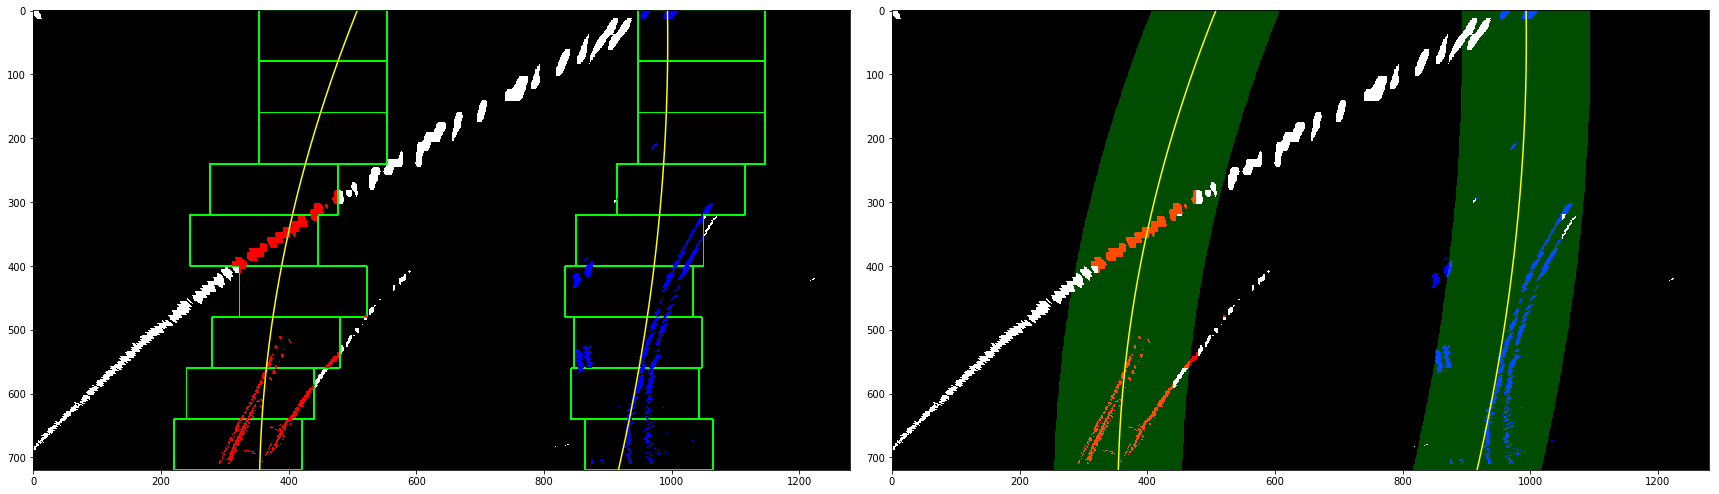

626.5593895592757 m 964.4828531833125 m


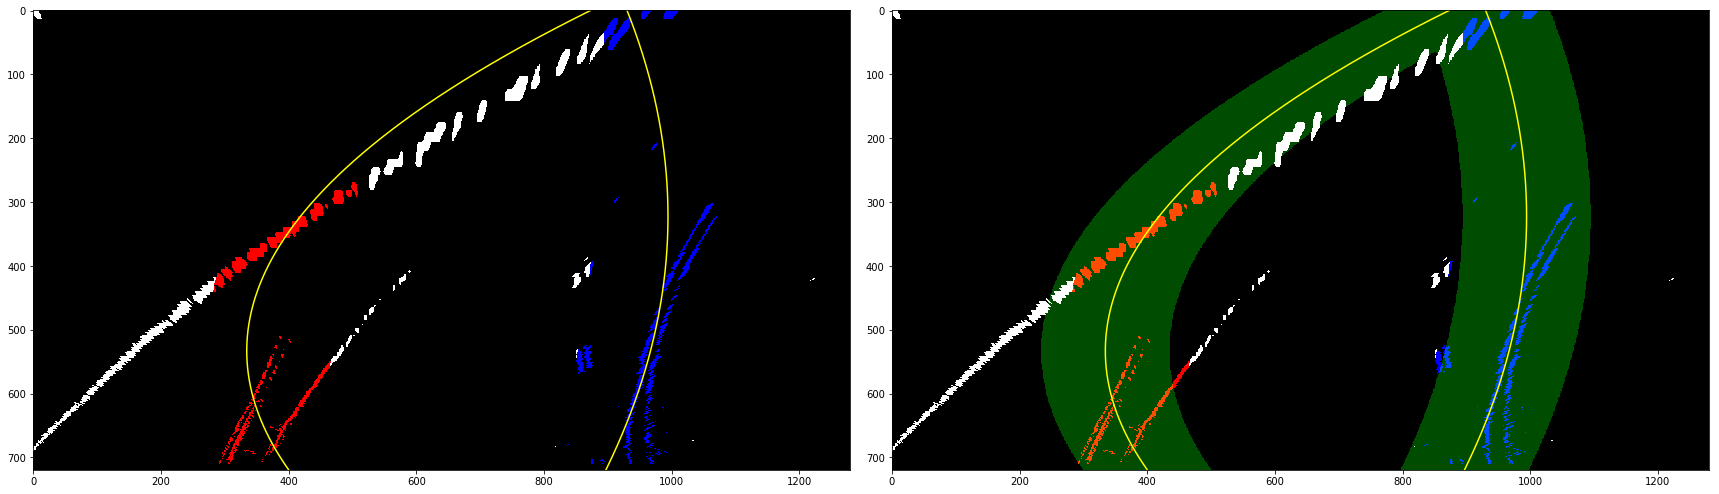

87.77194485643233 m 267.9212170443304 m


In [66]:
#Code Cell 13
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()        
binary_warped = np.copy(warped)
slideW = SlidingWindow()
out_img = slideW.sliding_window_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img, ax1)


result = slideW.plot_poly(binary_warped,ax2)


plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

image = mpimg.imread('./test_images/test3.jpg')
stacked, combined = pipeline(image)

M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()       
binary_warped = np.copy(warped)

out_img = slideW.no_sliding_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img,ax1)


result = slideW.plot_poly(binary_warped,ax2)

plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')

First Pass
./test_images/test5.jpg
First Pass


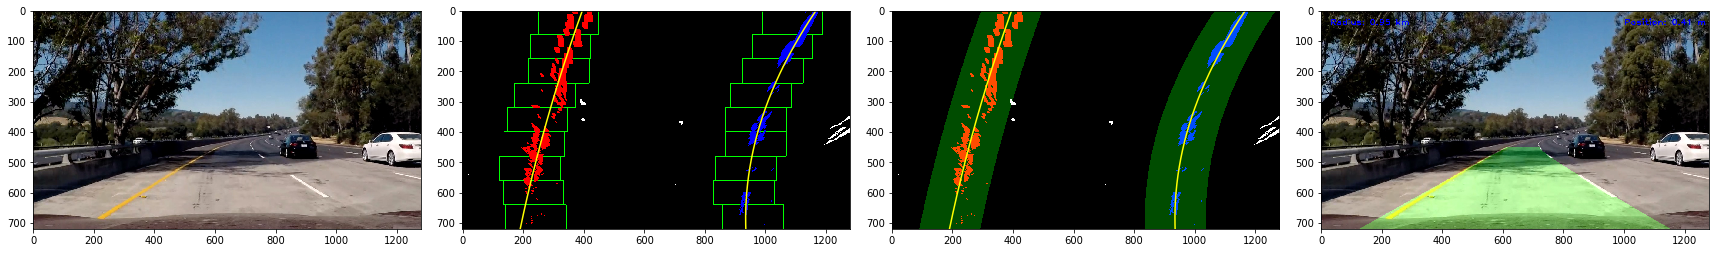

1568.3403528269382 m 332.7200654627532 m
./test_images/test6.jpg


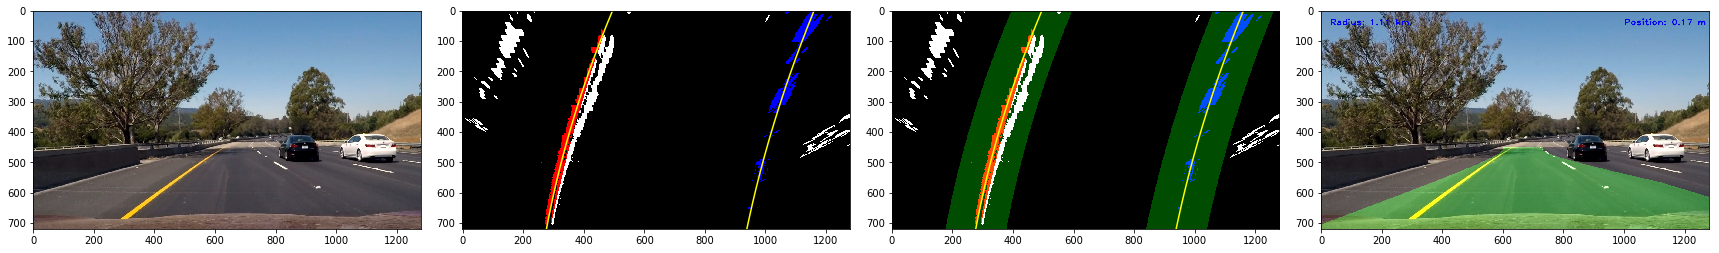

1021.3453866629367 m 1196.9565338321743 m
./test_images/test7.jpg
Old: 1196.9565338321743  New: 407.541283305612 Diff: 789.4152505265622
First Pass


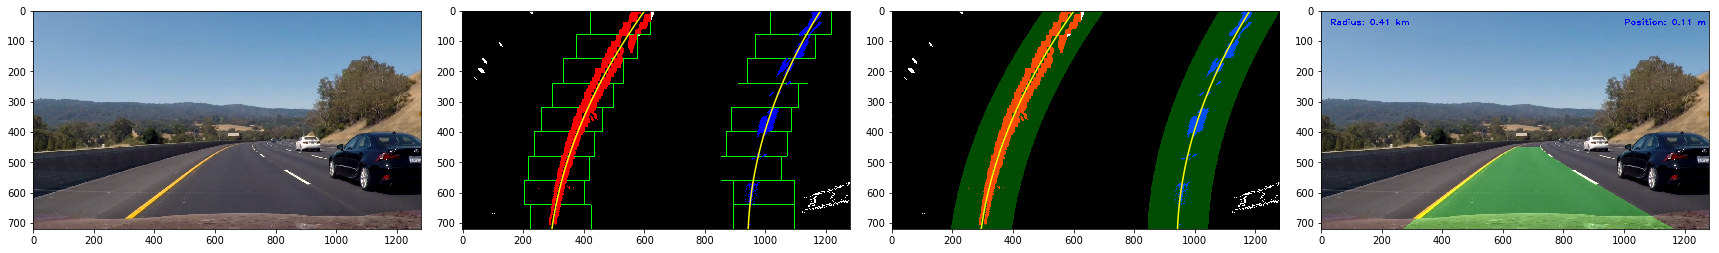

414.8724008180385 m 407.54128330582716 m
./test_images/test8.jpg


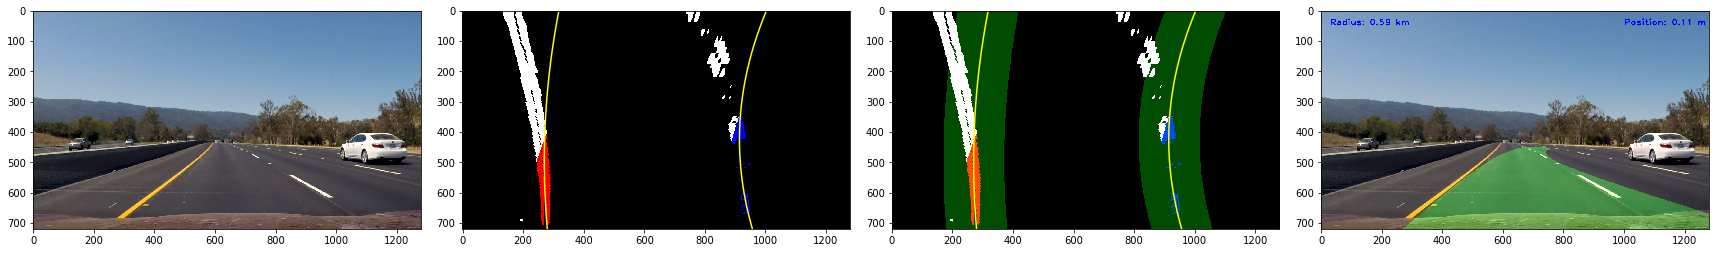

842.2117927419743 m 334.42688621061205 m
./test_images/test9.jpg


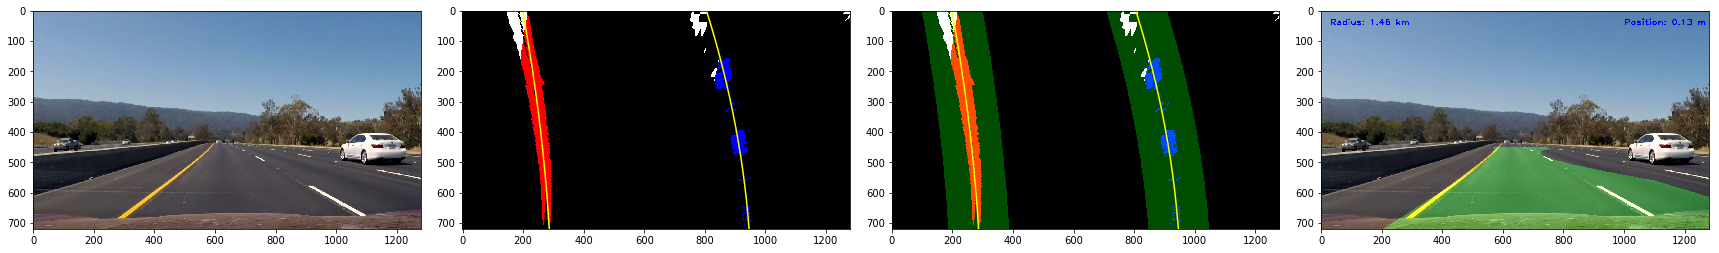

1920.3257777492327 m 991.8524797034316 m
./test_images/test10.jpg
Old: 1920.3257777492327  New: 56.43235262083362 Diff: 1863.893425128399
Old: 991.8524797034316  New: 237.9539372990855 Diff: 753.8985424043461
First Pass


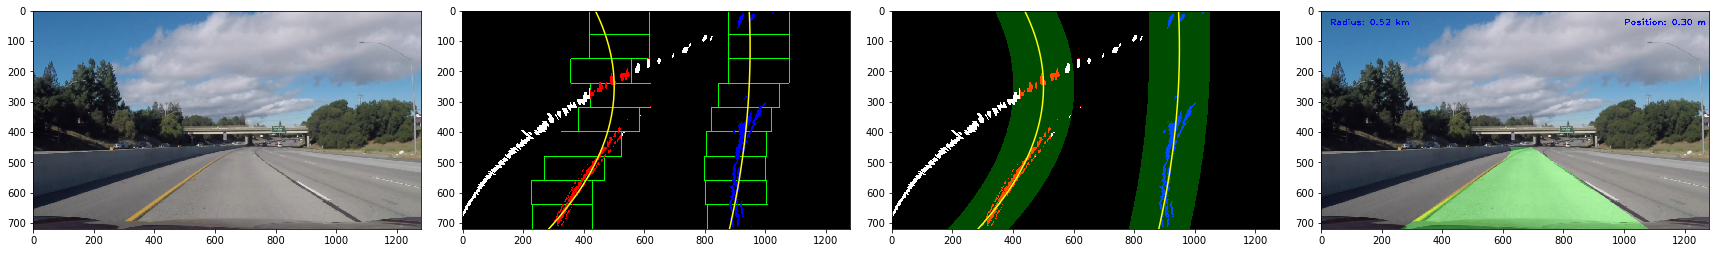

170.50512612650036 m 862.5010217713555 m
./test_images/test11.jpg
Old: 170.50512612650036  New: 9756.589820087715 Diff: 9586.084693961215
First Pass


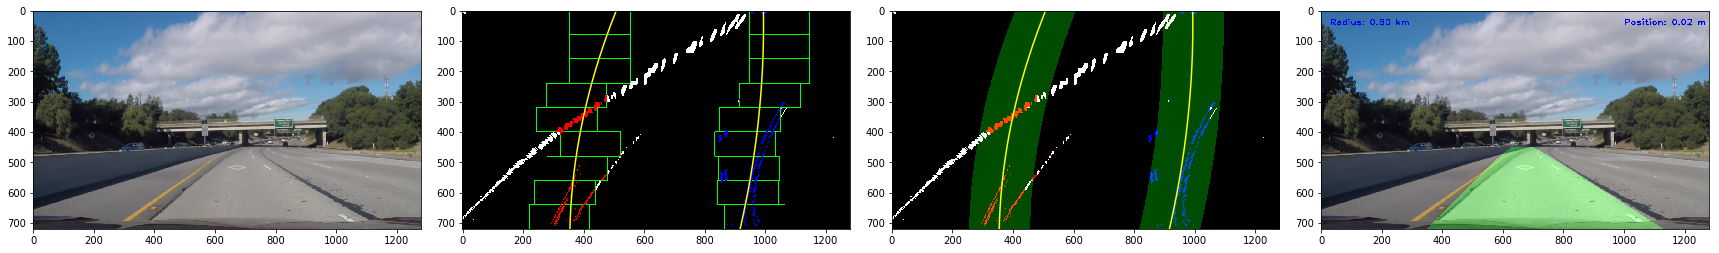

626.5593895592757 m 964.4828531833125 m


In [67]:
#Code Cell 14
images = glob.glob("./test_images/test*.jpg")

slide = SlidingWindow()
for n in range(5,12):

    fname = "./test_images/test%d.jpg" % n
    print (fname)
    image = mpimg.imread(fname)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    f, ax = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout() 
    ax[0].imshow(image)
    binary_warped = np.copy(warped)

    out_img = slide.polyfit(binary_warped)

    slide.plot_windows(binary_warped,out_img,ax[1])

    result = slide.plot_poly(binary_warped,ax[2])

    lanes = slide.drawLane(binary_warped,image,Minv)
    lanes = slide.drawData(lanes)

    ax[3].imshow(lanes)

    plt.show()

    left_curverad, right_curverad= slide.calc_curve()

    print(left_curverad, 'm', right_curverad, 'm')

In [68]:
#Code Cell 15
videoSlide = SlidingWindow()


def process_image(image):

    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    binary_warped = np.copy(warped)

    out_img = videoSlide.polyfit(binary_warped)

    lanes = videoSlide.drawLane(binary_warped,image,Minv)

    lanes = videoSlide.drawData(lanes)
    return lanes

First Pass


In [69]:
#Code Cell 16
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

First Pass
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



  0%|          | 4/1261 [00:01<08:28,  2.47it/s]

Old: 841.3364666022316  New: 374.6806508779256 Diff: 466.65581572430597
First Pass



  0%|          | 5/1261 [00:02<08:38,  2.42it/s]

Old: 715.258664068603  New: 328.86017793371974 Diff: 386.3984861348833
First Pass



  1%|          | 14/1261 [00:05<08:51,  2.34it/s]

Old: 3910.1985996263716  New: 950.1034945835808 Diff: 2960.0951050427907
First Pass



  1%|          | 15/1261 [00:06<08:51,  2.34it/s]

Old: 908.8725269354022  New: 464.1326541906351 Diff: 444.7398727447671
First Pass



  1%|▏         | 16/1261 [00:06<08:49,  2.35it/s]

Old: 851.5847038555522  New: 253.04087935662704 Diff: 598.5438244989252
First Pass



  2%|▏         | 31/1261 [00:12<09:14,  2.22it/s]

Old: 1145.0882412556193  New: 243.00449702248582 Diff: 902.0837442331335
First Pass



  3%|▎         | 32/1261 [00:13<09:10,  2.23it/s]

Old: 557.6714099722763  New: 258.34148564254934 Diff: 299.3299243297269
First Pass



  4%|▍         | 52/1261 [00:21<09:15,  2.17it/s]

Old: 1937.7724347042804  New: 893.3413824589629 Diff: 1044.4310522453175
First Pass



  4%|▍         | 53/1261 [00:22<09:08,  2.20it/s]

Old: 893.341382457833  New: 355.79551451036735 Diff: 537.5458679474657
First Pass



  4%|▍         | 54/1261 [00:22<09:02,  2.22it/s]

Old: 957.5010269379624  New: 276.8303959299162 Diff: 680.6706310080461
First Pass



  5%|▍         | 61/1261 [00:25<10:20,  1.93it/s]

Old: 527.644569485295  New: 279.5900942882928 Diff: 248.05447519700226
First Pass



  5%|▍         | 62/1261 [00:26<10:29,  1.90it/s]

Old: 880.0867690536639  New: 229.91776465838336 Diff: 650.1690043952806
First Pass



  5%|▍         | 63/1261 [00:27<10:15,  1.95it/s]

Old: 784.8605748837025  New: 195.18854830130022 Diff: 589.6720265824023
First Pass



  5%|▌         | 64/1261 [00:27<10:13,  1.95it/s]

Old: 492.7342574709699  New: 232.1455256555747 Diff: 260.58873181539525
First Pass



  5%|▌         | 65/1261 [00:28<10:12,  1.95it/s]

Old: 438.16326269547784  New: 222.26553542702305 Diff: 215.8977272684548
First Pass



  7%|▋         | 89/1261 [00:39<10:16,  1.90it/s]

Old: 555.0082125862485  New: 285.7979026063378 Diff: 269.21030997991073
First Pass



  7%|▋         | 90/1261 [00:40<09:58,  1.96it/s]

Old: 470.99984406007485  New: 220.11644077266772 Diff: 250.88340328740713
First Pass



 11%|█         | 141/1261 [01:01<08:08,  2.29it/s]

Old: 1008.3194914397818  New: 360.7544983318194 Diff: 647.5649931079624
First Pass



 11%|█▏        | 142/1261 [01:01<08:14,  2.26it/s]

Old: 754.6187208808007  New: 318.33993627240454 Diff: 436.2787846083961
First Pass



 13%|█▎        | 164/1261 [01:10<08:15,  2.21it/s]

Old: 743.2422084838113  New: 357.28359299395316 Diff: 385.9586154898581
First Pass



 13%|█▎        | 165/1261 [01:11<08:04,  2.26it/s]

Old: 501.1897393162059  New: 203.8380373236202 Diff: 297.3517019925857
First Pass



 17%|█▋        | 215/1261 [01:32<07:31,  2.31it/s]

Old: 790.506113468038  New: 294.2092395718268 Diff: 496.29687389621125
First Pass



 18%|█▊        | 226/1261 [01:36<07:31,  2.29it/s]

Old: 449.7725043848418  New: 247.85627946734647 Diff: 201.91622491749533
First Pass



 19%|█▊        | 236/1261 [01:40<07:27,  2.29it/s]

Old: 405.05962019003533  New: 224.96519676688544 Diff: 180.0944234231499
First Pass



 22%|██▏       | 272/1261 [01:55<07:16,  2.26it/s]

Old: 760.8721696836761  New: 408.28457811283533 Diff: 352.5875915708408
First Pass



 24%|██▍       | 307/1261 [02:10<07:33,  2.10it/s]

Old: 6713.453982434252  New: 3375.7688365523472 Diff: 3337.6851458819046
First Pass



 24%|██▍       | 308/1261 [02:10<07:27,  2.13it/s]

Old: 18977.924400707045  New: 7218.453961922078 Diff: 11759.470438784967
Old: 3375.7688365570716  New: 1643.05375491652 Diff: 1732.7150816405517
First Pass



 25%|██▍       | 312/1261 [02:12<06:49,  2.32it/s]

Old: 67741.35186628124  New: 21249.833111629778 Diff: 46491.518754651464
First Pass



 25%|██▍       | 313/1261 [02:12<06:55,  2.28it/s]

Old: 21249.833111792745  New: 9485.273108383126 Diff: 11764.560003409619
First Pass



 25%|██▌       | 318/1261 [02:14<06:40,  2.35it/s]

Old: 1634.9532996002874  New: 578.1483158107119 Diff: 1056.8049837895755
First Pass



 26%|██▌       | 326/1261 [02:18<07:13,  2.16it/s]

Old: 2110.8926843577233  New: 52090.8361089914 Diff: 49979.94342463368
First Pass



 26%|██▌       | 327/1261 [02:18<07:19,  2.12it/s]

Old: 52090.83611091175  New: 338353.71988767845 Diff: 286262.8837767667
First Pass



 26%|██▌       | 328/1261 [02:19<07:18,  2.13it/s]

Old: 338353.719837351  New: 6084.063245013947 Diff: 332269.65659233707
First Pass



 26%|██▌       | 330/1261 [02:20<07:16,  2.13it/s]

Old: 18050.895487374702  New: 6229.6756622469575 Diff: 11821.219825127744
First Pass



 26%|██▋       | 332/1261 [02:21<06:57,  2.22it/s]

Old: 11384.692295187624  New: 942.0877856195002 Diff: 10442.604509568124
First Pass



 27%|██▋       | 336/1261 [02:22<06:40,  2.31it/s]

Old: 6139.752911699432  New: 1128.9515800325955 Diff: 5010.801331666837
First Pass



 27%|██▋       | 340/1261 [02:24<06:40,  2.30it/s]

Old: 10215.261373298248  New: 1649.0330223879673 Diff: 8566.228350910282
First Pass



 27%|██▋       | 342/1261 [02:25<06:37,  2.31it/s]

Old: 3032.126778159575  New: 717.5352210105199 Diff: 2314.5915571490555
First Pass



 27%|██▋       | 344/1261 [02:26<06:36,  2.31it/s]

Old: 12358.60085075307  New: 92325.08687325536 Diff: 79966.4860225023
First Pass



 27%|██▋       | 345/1261 [02:26<06:43,  2.27it/s]

Old: 92325.08687423401  New: 48793.65464921327 Diff: 43531.43222502074
First Pass



 27%|██▋       | 346/1261 [02:26<06:47,  2.24it/s]

Old: 48793.654649567  New: 16713.187842819843 Diff: 32080.466806747154
First Pass



 28%|██▊       | 347/1261 [02:27<06:55,  2.20it/s]

Old: 16713.18784278492  New: 321001.9890766697 Diff: 304288.80123388476
First Pass



 28%|██▊       | 348/1261 [02:27<07:03,  2.16it/s]

Old: 321001.98898324213  New: 34129.820570231605 Diff: 286872.16841301054
First Pass



 28%|██▊       | 349/1261 [02:28<07:08,  2.13it/s]

Old: 34129.82057028221  New: 10425.86029629308 Diff: 23703.960273989127
First Pass



 28%|██▊       | 352/1261 [02:29<06:52,  2.20it/s]

Old: 27751.522670042006  New: 14556.07590456528 Diff: 13195.446765476727
First Pass



 28%|██▊       | 354/1261 [02:30<06:45,  2.24it/s]

Old: 18994.143127478193  New: 4589.422856494154 Diff: 14404.720270984039
Old: 2780.1766363812544  New: 54994.703069648865 Diff: 52214.52643326761
First Pass



 28%|██▊       | 355/1261 [02:31<06:58,  2.16it/s]

Old: 54994.703068357296  New: 4770.525768712658 Diff: 50224.17729964464
First Pass



 28%|██▊       | 356/1261 [02:31<07:08,  2.11it/s]

Old: 11376.584999689516  New: 5001.524352256333 Diff: 6375.060647433183
Old: 4770.525768699702  New: 2646.227091612917 Diff: 2124.298677086785
First Pass



 28%|██▊       | 357/1261 [02:32<07:08,  2.11it/s]

Old: 5001.5243522560395  New: 1415.9766965250842 Diff: 3585.5476557309553
Old: 2646.2270916116177  New: 962.6303171410756 Diff: 1683.5967744705422
First Pass



 29%|██▊       | 362/1261 [02:34<06:40,  2.24it/s]

Old: 1097.6475577577194  New: 9418.752786491636 Diff: 8321.105228733915
First Pass



 29%|██▉       | 363/1261 [02:34<06:52,  2.18it/s]

Old: 9418.752786406387  New: 4061.1278413419464 Diff: 5357.624945064441
First Pass



 29%|██▉       | 366/1261 [02:36<06:42,  2.22it/s]

Old: 11363.408949519897  New: 2346.0317626461133 Diff: 9017.377186873784
First Pass



 29%|██▉       | 369/1261 [02:37<06:25,  2.32it/s]

Old: 1840.282654985044  New: 959.0174733080464 Diff: 881.2651816769976
First Pass



 30%|██▉       | 377/1261 [02:40<06:48,  2.16it/s]

Old: 8546.250604764362  New: 1520.6239431763631 Diff: 7025.626661587999
First Pass



 30%|██▉       | 378/1261 [02:41<06:56,  2.12it/s]

Old: 1563.7898684151758  New: 24684.61632085131 Diff: 23120.826452436133
First Pass



 30%|███       | 379/1261 [02:41<06:56,  2.12it/s]

Old: 19145.394582320852  New: 9211.937602901937 Diff: 9933.456979418916
Old: 24684.616320501154  New: 7481.8890226896265 Diff: 17202.72729781153
First Pass



 30%|███       | 380/1261 [02:42<06:57,  2.11it/s]

Old: 7481.889022683605  New: 2217.9955884477745 Diff: 5263.89343423583
First Pass



 30%|███       | 383/1261 [02:43<06:42,  2.18it/s]

Old: 3732.0481567264615  New: 1589.4443482831566 Diff: 2142.603808443305
First Pass



 31%|███       | 390/1261 [02:46<06:30,  2.23it/s]

Old: 1843.8588778199346  New: 30991.75272882923 Diff: 29147.893851009296
First Pass



 31%|███       | 391/1261 [02:46<06:36,  2.19it/s]

Old: 30991.752729184373  New: 2683.3662678544033 Diff: 28308.38646132997
First Pass



 31%|███       | 393/1261 [02:47<06:34,  2.20it/s]

Old: 2053.8477279024346  New: 1085.7885382807851 Diff: 968.0591896216495
First Pass



 31%|███▏      | 395/1261 [02:48<06:25,  2.24it/s]

Old: 26754.90658546414  New: 396297.449786166 Diff: 369542.5432007019
First Pass



 31%|███▏      | 396/1261 [02:49<06:29,  2.22it/s]

Old: 396297.44976155163  New: 128535.69978164633 Diff: 267761.7499799053
First Pass



 31%|███▏      | 397/1261 [02:49<06:30,  2.21it/s]

Old: 128535.69977393342  New: 8304.703102050378 Diff: 120230.99667188304
First Pass



 32%|███▏      | 399/1261 [02:50<06:22,  2.25it/s]

Old: 1160.0133462059048  New: 17618.485746064045 Diff: 16458.47239985814
First Pass



 32%|███▏      | 400/1261 [02:50<06:22,  2.25it/s]

Old: 17618.485746216753  New: 1227.9599088072032 Diff: 16390.52583740955
First Pass



 32%|███▏      | 405/1261 [02:53<06:10,  2.31it/s]

Old: 7921.445535767592  New: 1657.4977181601698 Diff: 6263.947817607423
First Pass



 33%|███▎      | 410/1261 [02:55<06:03,  2.34it/s]

Old: 3080.645240745267  New: 1073.969650820527 Diff: 2006.67558992474
First Pass



 33%|███▎      | 412/1261 [02:55<06:03,  2.33it/s]

Old: 4311.3263799269525  New: 1363.5608388117064 Diff: 2947.7655411152464
First Pass



 33%|███▎      | 417/1261 [02:57<06:05,  2.31it/s]

Old: 6986.238415004174  New: 1350.7031855322628 Diff: 5635.535229471911
First Pass



 33%|███▎      | 420/1261 [02:59<05:59,  2.34it/s]

Old: 81981.14435872604  New: 5549.904104701193 Diff: 76431.24025402484
First Pass



 34%|███▎      | 424/1261 [03:00<05:58,  2.33it/s]

Old: 50284.43199705333  New: 5300.296944390046 Diff: 44984.13505266329
First Pass



 34%|███▍      | 427/1261 [03:02<05:56,  2.34it/s]

Old: 8278.086088732578  New: 2660.398028648971 Diff: 5617.688060083607
First Pass



 34%|███▍      | 429/1261 [03:02<05:56,  2.33it/s]

Old: 8908.04114522834  New: 4521.872499680706 Diff: 4386.168645547635
First Pass



 34%|███▍      | 430/1261 [03:03<06:04,  2.28it/s]

Old: 4521.872499683641  New: 23766.774887219788 Diff: 19244.902387536145
First Pass



 34%|███▍      | 431/1261 [03:03<06:08,  2.25it/s]

Old: 23766.774887324726  New: 4794.900971849874 Diff: 18971.87391547485
First Pass



 34%|███▍      | 433/1261 [03:04<06:01,  2.29it/s]

Old: 5375.880351086045  New: 87920.8504685182 Diff: 82544.97011743215
First Pass



 34%|███▍      | 434/1261 [03:05<06:05,  2.26it/s]

Old: 87920.85046595818  New: 12427.271776906187 Diff: 75493.578689052
First Pass



 34%|███▍      | 435/1261 [03:05<06:08,  2.24it/s]

Old: 12427.271776941983  New: 1036.5018673462316 Diff: 11390.769909595752
First Pass



 35%|███▍      | 440/1261 [03:07<05:52,  2.33it/s]

Old: 4475.483790110504  New: 2231.413931228238 Diff: 2244.0698588822656
First Pass



 35%|███▌      | 442/1261 [03:08<06:01,  2.27it/s]

Old: 2645.993613957527  New: 1381.208119375507 Diff: 1264.78549458202
First Pass



 35%|███▌      | 444/1261 [03:09<06:01,  2.26it/s]

Old: 2757.0533956108284  New: 1488.7722407394012 Diff: 1268.2811548714271
First Pass



 36%|███▌      | 452/1261 [03:12<06:09,  2.19it/s]

Old: 8455.946838983735  New: 63796.04544122606 Diff: 55340.098602242324
First Pass



 36%|███▌      | 453/1261 [03:13<06:09,  2.19it/s]

Old: 63796.045440326925  New: 8244.979532843201 Diff: 55551.065907483724
First Pass



 36%|███▌      | 455/1261 [03:14<06:00,  2.23it/s]

Old: 10847.318936608233  New: 4606.2790737020905 Diff: 6241.039862906143
First Pass



 36%|███▌      | 456/1261 [03:14<06:05,  2.20it/s]

Old: 4606.27907370856  New: 1905.1909061425456 Diff: 2701.088167566014
First Pass



 36%|███▋      | 458/1261 [03:15<05:55,  2.26it/s]

Old: 23876.919779797798  New: 12781.807814421845 Diff: 11095.111965375952
First Pass



 36%|███▋      | 459/1261 [03:15<05:56,  2.25it/s]

Old: 12781.80781436493  New: 568138.1000493456 Diff: 555356.2922349807
First Pass



 36%|███▋      | 460/1261 [03:16<05:56,  2.24it/s]

Old: 568138.0998841985  New: 15701.01091477831 Diff: 552437.0889694202
Old: 3712.34758638743  New: 1895.3272974435758 Diff: 1817.0202889438542
First Pass



 37%|███▋      | 464/1261 [03:18<05:48,  2.29it/s]

Old: 1912.6341189478424  New: 963.1632081024983 Diff: 949.4709108453441
First Pass



 37%|███▋      | 467/1261 [03:19<05:46,  2.29it/s]

Old: 17246.23965589174  New: 5755.471472585398 Diff: 11490.76818330634
First Pass



 37%|███▋      | 469/1261 [03:20<05:47,  2.28it/s]

Old: 13577.610492807828  New: 1860.3443519227424 Diff: 11717.266140885085
First Pass



 37%|███▋      | 471/1261 [03:21<05:44,  2.30it/s]

Old: 2726.6566831770783  New: 1196.085102031691 Diff: 1530.5715811453874
First Pass



 38%|███▊      | 476/1261 [03:23<06:01,  2.17it/s]

Old: 20001.800699920565  New: 2303.492250449381 Diff: 17698.308449471184
First Pass



 38%|███▊      | 478/1261 [03:24<06:14,  2.09it/s]

Old: 4097.667191103431  New: 1626.5183061881771 Diff: 2471.148884915254
First Pass



 38%|███▊      | 484/1261 [03:26<06:05,  2.13it/s]

Old: 4807.516821742973  New: 876.6538570130124 Diff: 3930.8629647299604
First Pass



 39%|███▉      | 489/1261 [03:29<05:53,  2.18it/s]

Old: 6262.900219364576  New: 33200.73629055703 Diff: 26937.836071192458
First Pass



 39%|███▉      | 490/1261 [03:29<05:59,  2.14it/s]

Old: 33200.73628904082  New: 6468.411469362915 Diff: 26732.324819677902
First Pass



 39%|███▉      | 491/1261 [03:30<06:07,  2.09it/s]

Old: 6468.411469377468  New: 2592.511855653766 Diff: 3875.8996137237023
First Pass



 39%|███▉      | 498/1261 [03:33<05:42,  2.23it/s]

Old: 1021.916750529796  New: 8573.82463960439 Diff: 7551.907889074595
First Pass



 40%|███▉      | 502/1261 [03:34<05:36,  2.26it/s]

Old: 16716.64436488038  New: 8637.862600909662 Diff: 8078.781763970717
First Pass



 40%|███▉      | 503/1261 [03:35<05:41,  2.22it/s]

Old: 8637.862600867124  New: 1709.3915785197744 Diff: 6928.471022347349
First Pass



 40%|████      | 506/1261 [03:36<05:34,  2.26it/s]

Old: 10992.197460541456  New: 4213.571642185928 Diff: 6778.625818355528
First Pass



 40%|████      | 508/1261 [03:37<05:30,  2.28it/s]

Old: 15384.271465654712  New: 4565.033006802562 Diff: 10819.238458852149
First Pass



 41%|████      | 513/1261 [03:39<05:24,  2.30it/s]

Old: 1372.093816433546  New: 22039.71261851906 Diff: 20667.618802085515
First Pass



 41%|████      | 514/1261 [03:39<05:32,  2.24it/s]

Old: 22039.712619100428  New: 3388.6608244433373 Diff: 18651.05179465709
First Pass



 41%|████      | 516/1261 [03:40<05:33,  2.23it/s]

Old: 3396.6145316247325  New: 1825.223063139789 Diff: 1571.3914684849435
First Pass



 41%|████      | 520/1261 [03:42<05:25,  2.27it/s]

Old: 3625.9830620282837  New: 42926.49380637603 Diff: 39300.51074434775
First Pass



 41%|████▏     | 521/1261 [03:42<05:28,  2.25it/s]

Old: 42926.49380524274  New: 2778.4367130998653 Diff: 40148.05709214287
First Pass



 41%|████▏     | 523/1261 [03:43<05:26,  2.26it/s]

Old: 3422.4606860548465  New: 1344.6298558730132 Diff: 2077.8308301818333
First Pass



 42%|████▏     | 524/1261 [03:44<05:31,  2.23it/s]

Old: 1744.2799043641785  New: 903.6925688562352 Diff: 840.5873355079433
Old: 895.5044644246434  New: 285.5911200465399 Diff: 609.9133443781035
First Pass



 42%|████▏     | 525/1261 [03:44<05:30,  2.23it/s]

Old: 826.097926527287  New: 438.4419265183273 Diff: 387.65600000895967
First Pass



 42%|████▏     | 533/1261 [03:47<05:09,  2.36it/s]

Old: 990.9649857905633  New: 541.9655228536002 Diff: 448.99946293696314
First Pass



 43%|████▎     | 541/1261 [03:50<04:30,  2.66it/s]

Old: 611.9850930099775  New: 3453.5761513610146 Diff: 2841.591058351037
First Pass



 43%|████▎     | 543/1261 [03:51<04:19,  2.76it/s]

Old: 6809.866490839099  New: 3644.0922931585083 Diff: 3165.774197680591
First Pass



 43%|████▎     | 544/1261 [03:51<04:19,  2.76it/s]

Old: 2871.864829100888  New: 1006.7768928522346 Diff: 1865.0879362486535
First Pass



 44%|████▍     | 556/1261 [03:55<03:54,  3.01it/s]

Old: 2478.570545472212  New: 487.70489171706794 Diff: 1990.865653755144
First Pass



 44%|████▍     | 561/1261 [03:57<03:55,  2.97it/s]

Old: 32.791522234557966  New: 10.94007720555425 Diff: 21.851445029003717
Old: 1839.1186124519006  New: 906.8616818022431 Diff: 932.2569306496575
First Pass



 45%|████▍     | 563/1261 [03:58<03:51,  3.01it/s]

Old: 46.4453083381447  New: 11.867328651535345 Diff: 34.57797968660935
First Pass



 45%|████▍     | 564/1261 [03:58<03:53,  2.98it/s]

Old: 1823.481996041521  New: 161.1051143242976 Diff: 1662.3768817172233
Old: 19226.85870859684  New: 1148.8902005016791 Diff: 18077.96850809516
First Pass



 45%|████▍     | 565/1261 [03:58<03:52,  2.99it/s]

Old: 161.10511432431957  New: 26.06628749422892 Diff: 135.03882683009064
First Pass



 45%|████▌     | 571/1261 [04:00<03:47,  3.03it/s]

Old: 208.77146711373564  New: 59.643592085503045 Diff: 149.1278750282326
First Pass



 46%|████▌     | 578/1261 [04:03<03:38,  3.13it/s]

Old: 3956.9837700174126  New: 784.9298042551604 Diff: 3172.053965762252
First Pass



 46%|████▋     | 584/1261 [04:05<03:43,  3.03it/s]

Old: 252.23013062737692  New: 3739.2439142504577 Diff: 3487.0137836230806
First Pass



 46%|████▋     | 585/1261 [04:05<03:53,  2.89it/s]

Old: 755.9908669129256  New: 101.92517111229681 Diff: 654.0656958006289
First Pass



 47%|████▋     | 588/1261 [04:06<03:51,  2.90it/s]

Old: 5646.738161415749  New: 141.87297611078066 Diff: 5504.865185304969
First Pass



 47%|████▋     | 592/1261 [04:07<03:39,  3.05it/s]

Old: 1043.3613491906078  New: 90.46707305315952 Diff: 952.8942761374483
First Pass



 47%|████▋     | 595/1261 [04:08<03:36,  3.07it/s]

Old: 7816.389807187098  New: 4203.035378996071 Diff: 3613.354428191027
First Pass



 47%|████▋     | 597/1261 [04:09<03:40,  3.01it/s]

Old: 336.89808424389065  New: 2402.6354269122116 Diff: 2065.737342668321
First Pass



 48%|████▊     | 599/1261 [04:09<03:41,  2.99it/s]

Old: 3049.8135133469495  New: 1387.9342015146515 Diff: 1661.879311832298
Old: 1905.8319477858686  New: 948.5816198482792 Diff: 957.2503279375894
First Pass



 48%|████▊     | 600/1261 [04:10<03:46,  2.91it/s]

Old: 225.84872392465465  New: 1155.8188827280303 Diff: 929.9701588033756
Old: 948.5816198487452  New: 518.3640676370163 Diff: 430.21755221172884
First Pass



 48%|████▊     | 602/1261 [04:11<03:56,  2.79it/s]

Old: 523.1766046908467  New: 281.1850733377427 Diff: 241.991531353104
First Pass



 48%|████▊     | 603/1261 [04:11<04:05,  2.68it/s]

Old: 471.9803762333394  New: 252.35821376183725 Diff: 219.62216247150218
First Pass



 60%|█████▉    | 754/1261 [05:16<03:39,  2.31it/s]


 63%|██████▎   | 796/1261 [05:34<03:29,  2.22it/s]

Old: 2367.8535387156408  New: 891.9561912464587 Diff: 1475.897347469182
First Pass



 69%|██████▉   | 876/1261 [06:08<02:55,  2.19it/s]

Old: 1858.8369870681656  New: 927.573448486353 Diff: 931.2635385818127
First Pass



 70%|███████   | 883/1261 [06:11<02:44,  2.30it/s]

Old: 448.3708626014464  New: 95.61136915654396 Diff: 352.75949344490243
First Pass



 71%|███████   | 895/1261 [06:16<02:45,  2.21it/s]

Old: 2013.474843906239  New: 940.7164814748911 Diff: 1072.758362431348
First Pass



 73%|███████▎  | 921/1261 [06:28<02:39,  2.13it/s]

Old: 1242.0313963896847  New: 681.82568306826 Diff: 560.2057133214247
First Pass



 73%|███████▎  | 923/1261 [06:28<02:32,  2.22it/s]

Old: 312.6277503597185  New: 128.00884769870618 Diff: 184.61890266101233
First Pass



 76%|███████▌  | 955/1261 [06:42<02:17,  2.23it/s]

Old: 3599.4680784575776  New: 1874.8237694035947 Diff: 1724.6443090539829
First Pass



 76%|███████▋  | 963/1261 [06:45<02:02,  2.43it/s]

Old: 461.2032033515331  New: 104.55522095304782 Diff: 356.6479823984853
First Pass



 77%|███████▋  | 972/1261 [06:49<01:58,  2.44it/s]

Old: 8429.13018117388  New: 3927.3670061432176 Diff: 4501.763175030662
First Pass



 77%|███████▋  | 973/1261 [06:49<01:56,  2.48it/s]

Old: 3746.5085120054464  New: 1835.9473651930373 Diff: 1910.561146812409
First Pass



 77%|███████▋  | 975/1261 [06:50<01:50,  2.58it/s]

Old: 1417.3889316412192  New: 322.4193804745815 Diff: 1094.9695511666378
First Pass



 77%|███████▋  | 976/1261 [06:50<01:50,  2.58it/s]

Old: 322.4193804746229  New: 11290.578727582597 Diff: 10968.159347107974
First Pass



 78%|███████▊  | 988/1261 [06:54<01:30,  3.01it/s]

Old: 1309.423484347453  New: 277.79727232284074 Diff: 1031.6262120246124
First Pass



 79%|███████▊  | 990/1261 [06:55<01:28,  3.06it/s]

Old: 446.91464628660395  New: 240.06815354137814 Diff: 206.84649274522582
First Pass



 79%|███████▊  | 991/1261 [06:55<01:28,  3.04it/s]

Old: 240.06815354140264  New: 97.41763633119844 Diff: 142.6505172102042
First Pass



 79%|███████▊  | 992/1261 [06:56<01:29,  3.01it/s]

Old: 96.26345310640606  New: 41.54978461005627 Diff: 54.71366849634979
First Pass



 79%|███████▉  | 997/1261 [06:57<01:23,  3.18it/s]

Old: 236.8609644983106  New: 2180.1073398645462 Diff: 1943.2463753662357
First Pass



 79%|███████▉  | 998/1261 [06:58<01:23,  3.16it/s]

Old: 50.3069485635403  New: 638.9322465921339 Diff: 588.6252980285935
First Pass



 79%|███████▉  | 1001/1261 [06:58<01:22,  3.14it/s]

Old: 608.7187233344405  New: 13897.271875884977 Diff: 13288.553152550536
First Pass



 81%|████████  | 1016/1261 [07:03<01:17,  3.15it/s]

Old: 92.5514448459402  New: 551.3224453374919 Diff: 458.7710004915517
First Pass



 83%|████████▎ | 1049/1261 [07:15<01:31,  2.32it/s]

Old: 1723.446371493561  New: 798.3672897125085 Diff: 925.0790817810524
First Pass



 84%|████████▎ | 1054/1261 [07:17<01:28,  2.33it/s]

Old: 2018.0115443791499  New: 496.2024265618125 Diff: 1521.8091178173374
First Pass



 85%|████████▌ | 1077/1261 [07:27<01:26,  2.12it/s]

Old: 826.5107555715109  New: 433.6471580443387 Diff: 392.8635975271722
First Pass



 87%|████████▋ | 1098/1261 [07:37<01:24,  1.93it/s]

Old: 2205.018191946411  New: 1171.2179606432442 Diff: 1033.800231303167
First Pass



 87%|████████▋ | 1100/1261 [07:38<01:17,  2.07it/s]

Old: 1034.4510698754507  New: 572.9303336241711 Diff: 461.5207362512796
First Pass



 98%|█████████▊| 1233/1261 [08:37<00:12,  2.17it/s]

Old: 638.3764918166103  New: 5916.94092898946 Diff: 5278.56443717285
First Pass



 98%|█████████▊| 1234/1261 [08:37<00:12,  2.16it/s]

Old: 5916.940928995392  New: 2637.036260623877 Diff: 3279.904668371515
First Pass



 98%|█████████▊| 1241/1261 [08:40<00:09,  2.16it/s]

Old: 1642.474467561095  New: 776.9867553950891 Diff: 865.487712166006
First Pass



 99%|█████████▉| 1247/1261 [08:43<00:06,  2.27it/s]

Old: 6354.194177083261  New: 1262.6119441641808 Diff: 5091.58223291908
First Pass



 99%|█████████▉| 1251/1261 [08:44<00:04,  2.38it/s]

Old: 23070.84450901601  New: 11414.813336955749 Diff: 11656.03117206026
First Pass



 99%|█████████▉| 1253/1261 [08:45<00:03,  2.40it/s]

Old: 2407.0692530319216  New: 1168.7262724301402 Diff: 1238.3429806017814
First Pass



100%|█████████▉| 1256/1261 [08:46<00:02,  2.40it/s]

Old: 2251.7457595102546  New: 43242.948282863064 Diff: 40991.20252335281
First Pass



100%|█████████▉| 1257/1261 [08:47<00:01,  2.34it/s]

Old: 43242.948281234865  New: 2322.4896959486523 Diff: 40920.458585286215
First Pass



100%|█████████▉| 1258/1261 [08:47<00:01,  2.31it/s]

Old: 76659.15090715617  New: 10052.18525535255 Diff: 66606.96565180362
Old: 2322.489695947887  New: 920.3450261285776 Diff: 1402.1446698193095
First Pass



100%|█████████▉| 1260/1261 [08:48<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 9min 58s, sys: 1min 40s, total: 11min 38s
Wall time: 8min 49s


In [ ]:
#Code Cell 17
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## Convolutional Approach
(Not Used, just for experimentation. Didn't seem as good as previous)

## Perspective Transform
